https://colab.research.google.com/github/numerai/example-scripts/blob/master/hello_numerai.ipynb  

In [1]:
import os
import json

import cloudpickle

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

In [2]:
napi = NumerAPI()
print(napi.get_current_round())

919


In [17]:
class cfg:
    data_version = "v4.3"
    feature_set = "medium"

In [18]:
with open(f"{cfg.data_version}/features.json", "r") as f:
    feature_metadata = json.load(f)

feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets[cfg.feature_set]

In [21]:
print(feature_metadata.keys())
print(feature_metadata["targets"])

dict_keys(['feature_stats', 'feature_sets', 'targets'])
['target', 'target_tyler_v4_20', 'target_tyler_v4_60', 'target_victor_v4_20', 'target_victor_v4_60', 'target_ralph_v4_20', 'target_ralph_v4_60', 'target_waldo_v4_20', 'target_waldo_v4_60', 'target_cyrus_v4_20', 'target_cyrus_v4_60', 'target_caroline_v4_20', 'target_caroline_v4_60', 'target_sam_v4_20', 'target_sam_v4_60', 'target_xerxes_v4_20', 'target_xerxes_v4_60', 'target_alpha_v4_20', 'target_alpha_v4_60', 'target_bravo_v4_20', 'target_bravo_v4_60', 'target_charlie_v4_20', 'target_charlie_v4_60', 'target_delta_v4_20', 'target_delta_v4_60', 'target_echo_v4_20', 'target_echo_v4_60', 'target_jerome_v4_20', 'target_jerome_v4_60', 'target_ben_v4_20', 'target_ben_v4_60', 'target_jeremy_v4_20', 'target_jeremy_v4_60', 'target_teager_v4_20', 'target_teager_v4_60', 'target_agnes_v4_20', 'target_agnes_v4_60', 'target_claudia_v4_20', 'target_claudia_v4_60', 'target_rowan_v4_20', 'target_rowan_v4_60']


In [4]:
train = pd.read_parquet(
    f"{cfg.data_version}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)
print(train.shape)
display(train.head(2))

(2420521, 707)


,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0,4,0,4,2,0,2,1,...,0,0,2,4,2,4,3,2,2,3
n003bee128c2fcfc,0001,0.75,4,2,2,2,2,3,2,1,...,3,3,2,0,2,2,1,3,2,1


,era,count
0,1,2072
1,2,2260


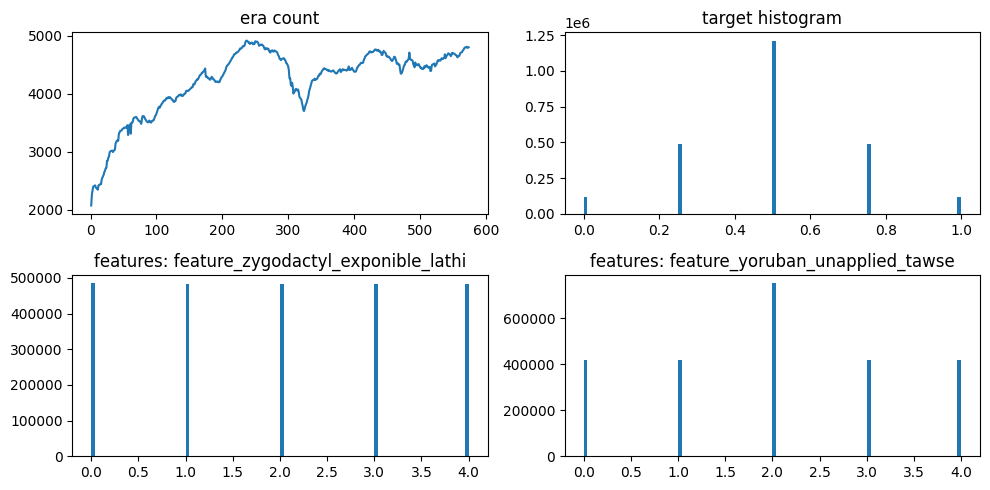

In [5]:
# era は 1週間単位
# era 毎の件数
era_cnt = train["era"].value_counts().reset_index().sort_values("era").astype({"era": np.int64}).reset_index(drop=True)

display(era_cnt.head(2))

_, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].plot(era_cnt["era"], era_cnt["count"])
ax[0][0].set_title("era count")

# ターゲットのヒストグラム
ax[0][1].hist(train["target"], bins=100)
ax[0][1].set_title("target histogram")

# 適当な特徴量のヒストグラム
ax[1][0].hist(train[train.columns[-1]].values, bins=100)
ax[1][0].set_title(f"features: {train.columns[-1]}")

# 適当な特徴量のヒストグラム2
ax[1][1].hist(train[train.columns[-2]].values, bins=100)
ax[1][1].set_title(f"features: {train.columns[-2]}")

plt.tight_layout()
plt.show()

特徴とは、PER などのファンダメンタルズ、RSI などのテクニカルシグナル、空売りなど の市場データ、アナリスト評価などの二次データなど、各銘柄の定量的な属性です。

各特徴の基本的な定義は重要ではありません。ただ、Numeraiがこれらの特徴をデータセットに含めているのは、これらの特徴が単独で、あるいは他の特徴と組み合わせて、ターゲットを予測できると考えているからです。

特徴量は0、1、2、3、4の5つのビンに分類される。このように特徴値を正則化するのは、基礎となる値が非常にノイジーであるため、オーバーフィッティングを避けるためである。ターゲットとは異なり、データセット全体のストレージの必要性を減らすために、これらは浮動小数点ではなく整数である。

その時代で特定の特徴のデータが欠落している場合（初期の時代に多い）、すべての値が2に設定される。

In [6]:
model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1,
)

model.fit(
    train[feature_set],
    train["target"]
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in the train set: 2420521, number of used features: 705
[LightGBM] [Info] Start training from score 0.500015


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

In [8]:
validation = pd.read_parquet(
    f"{cfg.data_version}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)

validation = validation[validation["data_type"]=="validation"]
del validation["data_type"]

# train期間に近いデータを除外
last_train_era = int(train["era"].unique().max())
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

In [9]:
validation["prediction"] = model.predict(validation[feature_set])

validation["meta_model"] = pd.read_parquet(
    f"{cfg.data_version}/meta_model.parquet"
)["numerai_meta_model"]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [10]:
# corr: 目的変数と予測値の相関
# mmc:  メタモデルへの寄与度（自身のモデルからメタモデルとの相関を取り除いた残りの部分(残差)とリターンの相関） 
per_era_corr = validation.groupby("era").apply(lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()))
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)

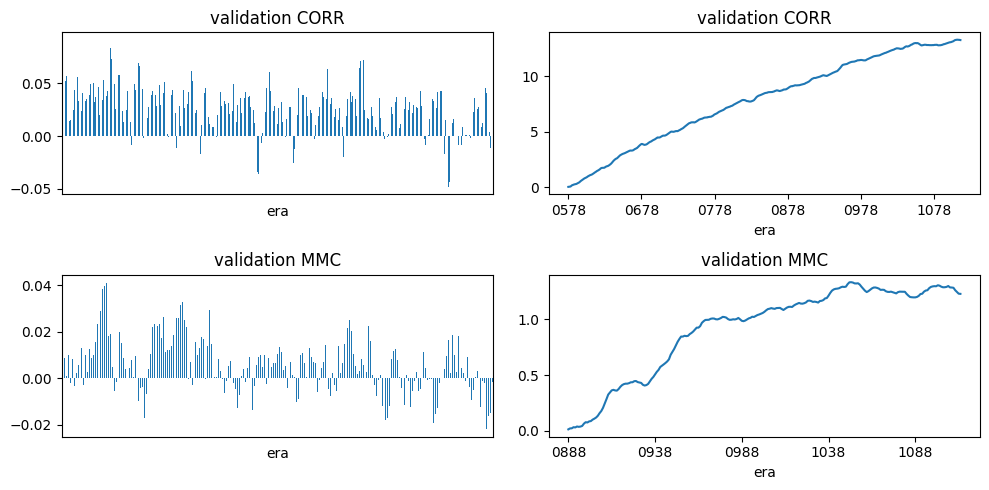

In [11]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
per_era_corr.plot(title="validation CORR", kind="bar", xticks=[], legend=False, ax=ax[0][0])
per_era_corr.cumsum().plot(title="validation CORR", kind="line", legend=False, ax=ax[0][1])
per_era_mmc.plot(title="validation MMC", kind="bar", xticks=[], legend=False, ax=ax[1][0])
per_era_mmc.cumsum().plot(title="validation MMC", kind="line", legend=False, ax=ax[1][1])

plt.tight_layout()
plt.show()

In [12]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.024738 dtype: float64,prediction 0.005411 dtype: float64
std,prediction 0.022574 dtype: float64,prediction 0.011386 dtype: float64
sharpe,prediction 1.095879 dtype: float64,prediction 0.475273 dtype: float64
max_drawdown,prediction 0.217367 dtype: float64,prediction 0.136091 dtype: float64


# Predict

In [13]:
live_features = pd.read_parquet(f"{cfg.data_version}/live_int8.parquet", columns=feature_set)
live_features["predict"]= model.predict(live_features[feature_set])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [14]:
# 推論処理の関数をアップロードすると自動でやってくれるらしい
# この中にモデルの情報も入ってるの？
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_set])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

p = cloudpickle.dumps(predict)
with open("../output/predict.pkl", "wb") as f:
    f.write(p)

In [15]:
display(live_features.head(2))

,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,feature_adsorbed_blizzardy_burlesque,feature_affettuoso_taxidermic_greg,...,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi,predict
id,,,,,,,,,,,,,,,,,,,,,
n00183c391a8c8ca,2,3,3,3,2,2,4,4,4,3,...,1,3,3,4,4,4,4,3,3,0.512686
n001ac76d75816b8,2,1,3,3,2,4,2,2,2,3,...,4,0,4,0,1,3,3,1,4,0.498450
